In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import os
import cv2
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

input_dir = '/kaggle/input/isic-skin-disease-image-dataset-labelled/ISIC_Labelled/Squamous cell carcinoma/'  
noisy_dir = '/kaggle/working/noisy_images/' 
os.makedirs(noisy_dir, exist_ok=True)

def add_gaussian_noise(image, mean=0, sigma=25):
    row, col, ch = image.shape
    gauss = np.random.normal(mean, sigma, (row, col, ch)).astype('uint8')
    noisy_image = cv2.add(image, gauss)
    return noisy_image


for filename in os.listdir(input_dir):
    if filename.endswith('.png') or filename.endswith('.jpg'):
        image_path = os.path.join(input_dir, filename)
        image = cv2.imread(image_path)
        if image is not None:
            noisy_image = add_gaussian_noise(image)
            noisy_image_path = os.path.join(noisy_dir, filename)
            cv2.imwrite(noisy_image_path, noisy_image)
        else:
            print(f"Failed to read {image_path}")

print("Noisy images have been saved.")


Noisy images have been saved.


In [5]:
class MedicalDataset(Dataset):
    def __init__(self, root_dir, noisy_dir, transform=None):
        self.root_dir = root_dir
        self.noisy_dir = noisy_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.png') or f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        noisy_img_name = os.path.join(self.noisy_dir, self.image_files[idx])
        
        image = Image.open(img_name)
        noisy_image = Image.open(noisy_img_name)
        
        if self.transform:
            image = self.transform(image)
            noisy_image = self.transform(noisy_image)
        
        return {'image': image, 'noisy_image': noisy_image}

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

dataset = MedicalDataset(input_dir, noisy_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils

class UNetDown(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        layers = [nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False)]
        if normalize:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class UNetUp(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super(UNetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)
        return x

class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorUNet, self).__init__()
        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512, dropout=0.5)
        self.down5 = UNetDown(512, 512, dropout=0.5)
        self.down6 = UNetDown(512, 512, dropout=0.5)
        self.down7 = UNetDown(512, 512, dropout=0.5)
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5)
        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 512, dropout=0.5)
        self.up4 = UNetUp(1024, 512, dropout=0.5)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64)
        self.final = nn.Sequential(
            nn.ConvTranspose2d(128, out_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)
        return self.final(u7)


In [ ]:
num_epochs = 1200
lr = 0.0002
beta1 = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = GeneratorUNet().to(device)
optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
criterion = nn.L1Loss()
start_epoch = 0
checkpoint_path = 'pix2pix_checkpoint.pth'

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    generator.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    print(f"Checkpoint loaded. Resuming from epoch {start_epoch}.")
output_dir = '/kaggle/working/output_images/'
os.makedirs(output_dir, exist_ok=True)


for epoch in range(start_epoch, num_epochs):
    for i, batch in enumerate(dataloader):
        real_A = batch['noisy_image'].to(device)
        real_B = batch['image'].to(device)

        optimizer.zero_grad()
        fake_B = generator(real_A)
        loss = criterion(fake_B, real_B)
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Loss: {loss.item():.4f}')


         
        if (epoch + 1) % 10 == 0 and i == 0:
            vutils.save_image(fake_B.data, os.path.join(output_dir, f'fake_samples_epoch_{epoch+1}_step_{i+1}.png'), normalize=True)
            vutils.save_image(real_B.data, os.path.join(output_dir, f'real_samples_epoch_{epoch+1}_step_{i+1}.png'), normalize=True)
            vutils.save_image(real_A.data, os.path.join(output_dir, f'noisy_samples_epoch_{epoch+1}_step_{i+1}.png'), normalize=True)

    if (epoch + 1) % 100 == 0:
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': generator.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, checkpoint_path)
        print(f'Checkpoint saved at epoch {epoch+1}.')


In [3]:
import os

def make_directory(directory_path):
    try:

        if not os.path.exists(directory_path):

            os.makedirs(directory_path)
            print(f"Directory created: {directory_path}")
        else:
            print(f"Directory already exists: {directory_path}")
    except Exception as e:
        print(f"An error occurred: {e}")


directory_path = '/kaggle/working/output_images/'


make_directory(directory_path)


Directory already exists: /kaggle/working/output_images/


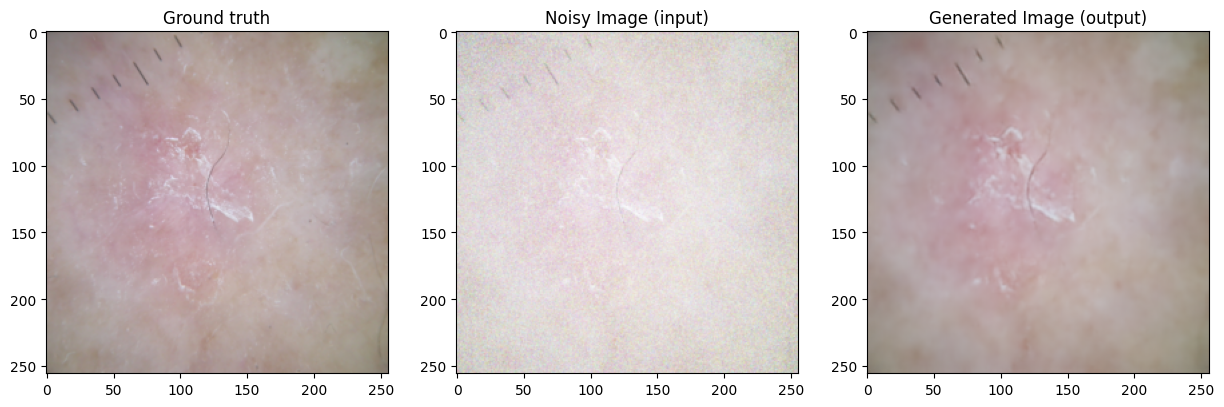

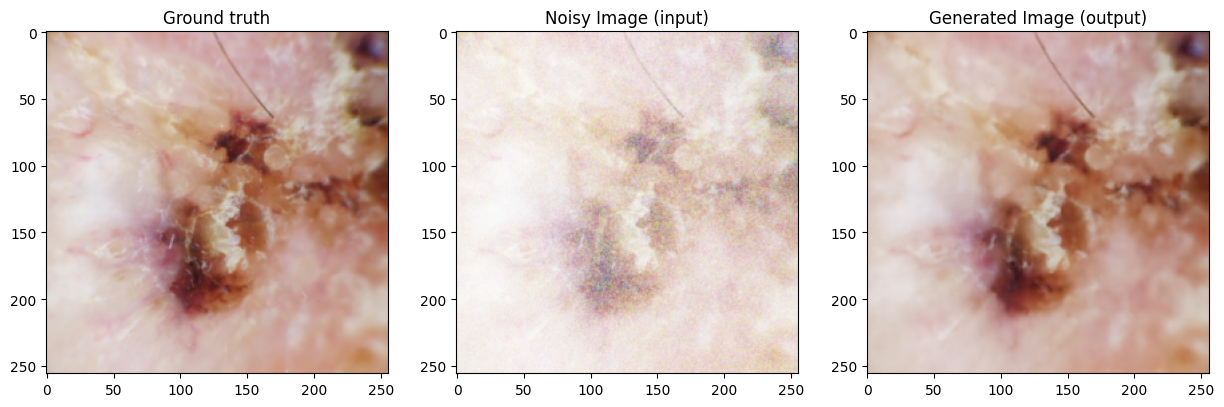

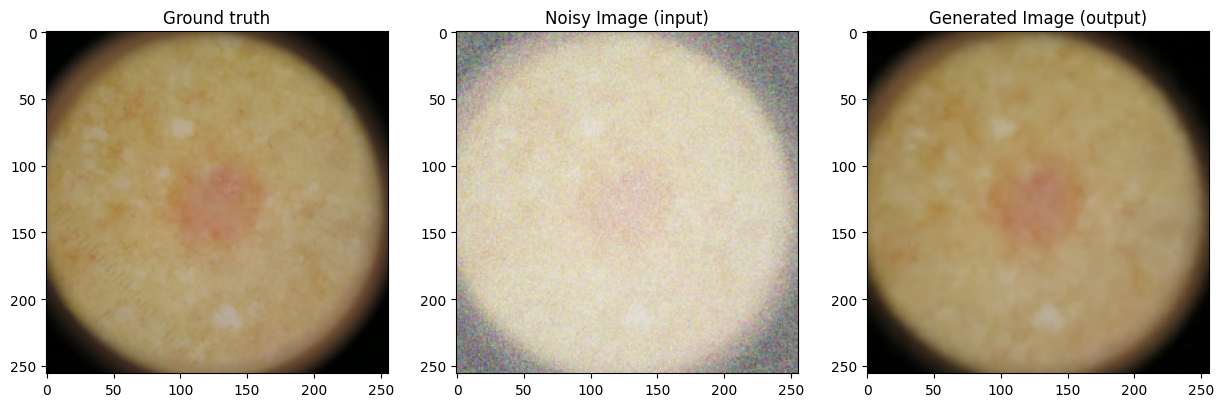

In [11]:
import matplotlib.pyplot as plt

def show_images(original, noisy, generated):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(np.transpose(original, (1, 2, 0)))
    axes[0].set_title("Ground truth")
    axes[1].imshow(np.transpose(noisy, (1, 2, 0)))
    axes[1].set_title("Noisy Image (input)")
    axes[2].imshow(np.transpose(generated, (1, 2, 0)))
    axes[2].set_title("Generated Image (output)")
    plt.show()


dataiter = iter(dataloader)
for _ in range(3):
    batch = next(dataiter)
    real_A = batch['noisy_image'].to(device)
    real_B = batch['image'].to(device)
    with torch.no_grad():
        fake_B = generator(real_A)
    
    show_images(real_B.cpu().numpy()[0], real_A.cpu().numpy()[0], fake_B.cpu().numpy()[0])
